# Lab 5-3: Mixing length theory at Kettle Ponds

Written by Eli Schwat - February 2024.

In [1]:
import xarray as xr
import numpy as np
import os 
import urllib
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import altair as alt

## SOS Data

In [2]:
sos_file = "../data/sos_full_dataset_30min.nc"
sos_dataset = xr.open_dataset(sos_file)

## Plotting velocity profiles during different stability conditions

The dataset already has temperature gradients (that indicate stability) calculated.

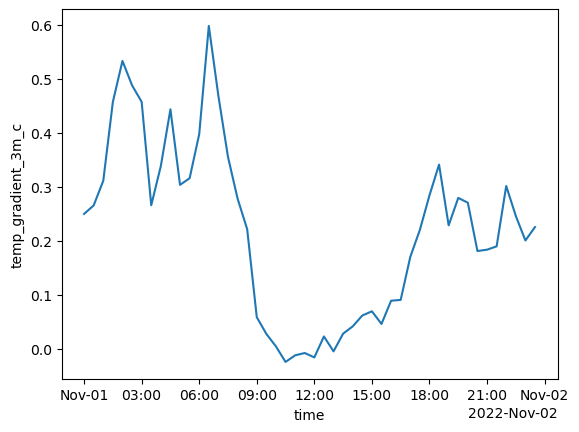

In [55]:
sos_dataset['temp_gradient_3m_c'].loc['20221101'].plot()

We can see that the atmosphere was stable except for the middle of the day

Let's look at velocity profiles at different times of the day. What do we expect them to look like?

In [56]:
wind_df = sos_dataset[[
    'spd_1m_c',
    'spd_2m_c',
    'spd_3m_c',
    'spd_5m_c',
    'spd_10m_c',
    'spd_15m_c',
    'spd_20m_c',  
]].to_dataframe().melt(ignore_index=False)
# Extract the number from the string in the 'column'
wind_df['height'] = wind_df['variable'].str.extract('(\d+)').astype('int')
wind_df

,variable,value,height
time,,,
2022-11-01 00:00:00,spd_1m_c,0.847002,1
2022-11-01 00:30:00,spd_1m_c,1.782696,1
2022-11-01 01:00:00,spd_1m_c,1.118848,1
2022-11-01 01:30:00,spd_1m_c,1.762465,1
2022-11-01 02:00:00,spd_1m_c,1.999188,1
...,...,...,...
2023-06-19 15:30:00,spd_20m_c,3.620165,20
2023-06-19 16:00:00,spd_20m_c,5.240737,20
2023-06-19 16:30:00,spd_20m_c,4.676786,20


Let's look at wind velocity profiles at 12pm (near neutral conditions)

Here, we plot both in linear space (left plot) and log space (right plot)

In [18]:
base = alt.Chart(
    wind_df.loc['20221101 1200']
).mark_circle(size=50).encode(
    alt.X('value:Q')
).properties(width=150, height = 150)

(
    base.encode(alt.Y('height:Q'))
    |
    base.encode(alt.Y('height:Q').scale(type='log'))
)


alt.HConcatChart(...)

How about at 5pm during stable conditions?

In [90]:
base = alt.Chart(
    wind_df.loc['20221101 1700']
).mark_circle(size=50).encode(
    alt.X('value:Q')
).properties(width=150, height = 150)

(
    base.encode(alt.Y('height:Q'))
    |
    base.encode(alt.Y('height:Q').scale(type='log'))
)


alt.HConcatChart(...)

We see that the wind profile is not quite logarithmic...it seems to depart from a logarithmic curve higher up.

Why would the velocity profile depart from the log curve like it does above, during stable conditions?

# Fitting a log profile to the measured velocity profile

Let's fit a wind profile to the 1200 data

$$ \overline{u} = \frac{u^*}{k}log(z / z_0)$$

For this exercise, we will assume a z0 value, but we could calculate it if we wanted to.

We will also extract a measured $u^*$ value.

In [96]:
sos_dataset[[
    'u*_3m_c',
    'u*_5m_c',
    'u*_10m_c',
    'u*_15m_c',
]].to_dataframe().loc['20221101 1200']

u*_3m_c     0.046698
u*_5m_c     0.066276
u*_10m_c    0.101627
u*_15m_c    0.110692
Name: 2022-11-01 12:00:00, dtype: float64

In [111]:
ustar_df = sos_dataset[[
    'u*_3m_c',
]].to_dataframe().melt(ignore_index=False)

In [112]:
z0 = 0.001

ustar = ustar_df.loc['20221101 1200'].value

<function matplotlib.pyplot.legend(*args, **kwargs) -> 'Legend'>

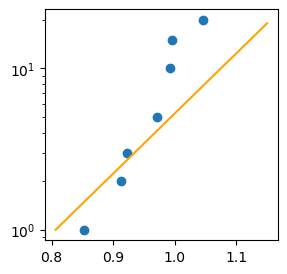

In [113]:
plt.figure(figsize=(3,3))
plt.scatter(
    wind_df.loc['20221101 1200']['value'],
    wind_df.loc['20221101 1200']['height'],
    label='measured'
)
plt.plot(
    (ustar / 0.4)*np.log(np.arange(1,20,1) / z0),
    np.arange(1,20,1),
    color='orange',
    label='fit'
)
plt.yscale('log')
plt.legend

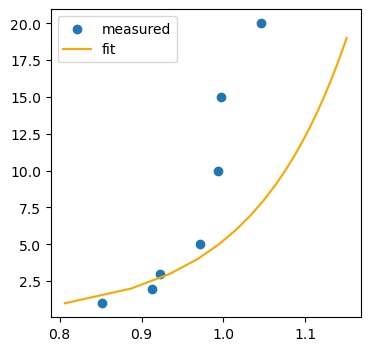

In [114]:
plt.figure(figsize=(4,4))
plt.scatter(
    wind_df.loc['20221101 1200']['value'],
    wind_df.loc['20221101 1200']['height'],
    label='measured'
)
plt.plot(
    (ustar / 0.4)*np.log(np.arange(1,20,1) / z0),
    np.arange(1,20,1),
    color='orange',
    label='fit'
)
plt.legend()

How could we extract $z_0$ and $u^*$ from the data?

$$ \overline{u} = \frac{u^*}{k}log(z / z_0)$$